<a href="https://colab.research.google.com/github/piyushirish/drowsiness-detection/blob/main/lane_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/datasets.zip'  # Replace with your file path
extract_path = '/content/dataset1'  # Path to extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence


In [ ]:
# Paths to images and masks
frames_path = "/content/dataset1/datasets/frames1"
lane_marks_path = "/content/dataset1/datasets/lane-masks1"

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 512

# Data generator class
class LaneDataGenerator(Sequence):
    def __init__(self, image_list, mask_list, batch_size):
        self.image_list = image_list
        self.mask_list = mask_list
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_list) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_list[idx * self.batch_size:(idx + 1) * self.batch_size]

        images, masks = [], []
        for img, mask in zip(batch_images, batch_masks):
            img = cv2.imread(img, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0  # Normalize

            mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
            mask = np.expand_dims(mask, axis=-1)
            mask = mask / 255.0  # Normalize

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)


In [ ]:
# Get image and mask paths
images = sorted([os.path.join(frames_path, f) for f in os.listdir(frames_path)])
masks = sorted([os.path.join(lane_marks_path, f) for f in os.listdir(lane_marks_path)])

# Split into train-test
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create generators
batch_size = 8
train_gen = LaneDataGenerator(train_images, train_masks, batch_size)
val_gen = LaneDataGenerator(val_images, val_masks, batch_size)


In [ ]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(c3)

    # Decoder
    u2 = UpSampling2D((2,2))(c3)
    u2 = concatenate([u2, c2])
    c4 = Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    c4 = Conv2D(32, (3,3), activation='relu', padding='same')(c4)

    u1 = UpSampling2D((2,2))(c4)
    u1 = concatenate([u1, c1])
    c5 = Conv2D(16, (3,3), activation='relu', padding='same')(u1)
    c5 = Conv2D(16, (3,3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model


In [ ]:
# Build the model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 20
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 512, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 512, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 256, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 256, 32)   │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 128, 32)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 128, 64)    │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 128, 64)    │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 256, 64)   │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 256, 96)   │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 256, 32)   │         27,680 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 256, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 512, 32)   │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 512, 48)   │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 512, 16)   │          6,928 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 185ms/step - accuracy: 0.7905 - loss: 0.4523 - val_accuracy: 0.9429 - val_loss: 0.1632
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 143ms/step - accuracy: 0.9422 - loss: 0.1579 - val_accuracy: 0.9429 - val_loss: 0.1537
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.9421 - loss: 0.1421 - val_accuracy: 0.9429 - val_loss: 0.1327
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.9421 - loss: 0.1328 - val_accuracy: 0.9429 - val_loss: 0.1272
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9425 - loss: 0.1277 - val_accuracy: 0.9452 - val_loss: 0.1214
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.9451 - loss: 0.1195 - val_accuracy: 0.9460 - val_loss: 0.1136
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 144ms/step - accuracy: 0.9455 - loss: 0.1143 - val_accuracy: 0.9469 - val_loss: 0.1082
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.9460 - loss: 0.1090 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


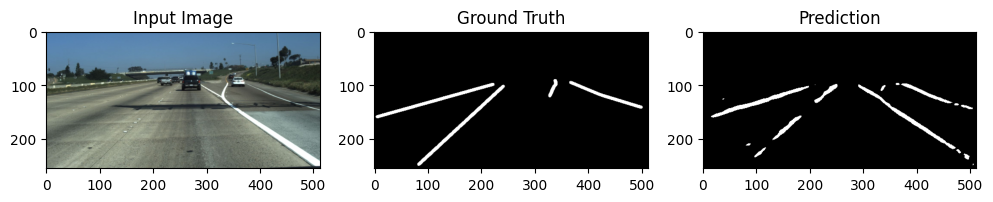

In [ ]:
# Save the model
model.save("lane_detection_model1.h5")

# Test and visualize predictions
def visualize_predictions(model, image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_norm = img_resized / 255.0

    pred = model.predict(np.expand_dims(img_norm, axis=0))[0]
    pred = (pred > 0.5).astype(np.uint8) * 255

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred, cmap='gray')
    plt.show()

# Example prediction
visualize_predictions(model, val_images[0], val_masks[0])


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("lane_detection_model1.h5")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Image dimensions (must match the training dimensions)
IMG_HEIGHT, IMG_WIDTH = 256, 512

def preprocess_image(image_path):
    # Load the external image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_norm = img_resized / 255.0  # Normalize to [0, 1]

    return img, np.expand_dims(img_norm, axis=0)  # Return original and preprocessed image


In [ ]:
def predict_lane(model, image_path):
    original_img, preprocessed_img = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(preprocessed_img)[0]  # Shape: (256, 512, 1)
    prediction = (prediction > 0.5).astype(np.uint8) * 255  # Binary mask

    # Resize mask back to original image size
    lane_mask = cv2.resize(prediction, (original_img.shape[1], original_img.shape[0]))

    return original_img, lane_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


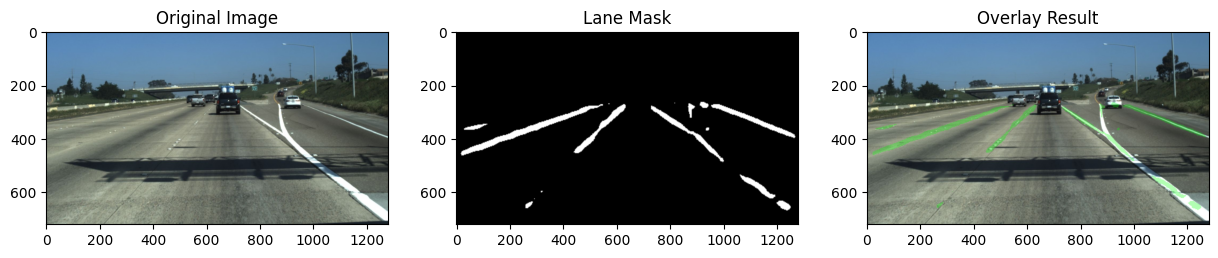

In [ ]:
def overlay_lane(original_img, lane_mask):
    lane_overlay = original_img.copy()
    lane_overlay[lane_mask == 255] = [0, 255, 0]  # Highlight lanes in green

    # Blend the original image and overlay
    blended = cv2.addWeighted(original_img, 0.7, lane_overlay, 0.3, 0)
    return blended

# Predict and visualize
image_path = "/content/0313-2_300.jpg"  # Replace with your image path
original_img, lane_mask = predict_lane(model, image_path)
result = overlay_lane(original_img, lane_mask)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Lane Mask")
plt.imshow(lane_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Overlay Result")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
# Save the lane mask
cv2.imwrite("lane_mask.png", lane_mask)

# Save the overlay result
cv2.imwrite("overlay_result.png", result)

print("Lane mask saved as lane_mask.png")
print("Overlay image saved as overlay_result.png")


Lane mask saved as lane_mask.png
Overlay image saved as overlay_result.png


In [ ]:
cv2.imwrite("Original_Image.png", lane_mask)
print("Original_Image saved as Original_Image.png")


Original_Image saved as Original_Image.png
